# Weather Station Data - cleaned final version 
## Level 1 QC

In [20]:
#import external libraries
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'; chained index warning
import numpy as np
import imp
import datetime
import pytz

#plotting
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import LVL1

** Define Location-Specific Baseline Settings **

In [21]:
#path to level 0 data
Glacier="Wolverine" #or "Gulkana"
Station="990" #or other elevations; this depends on the naming convention of input data
timezone='America/Anchorage' #choose from pytz.all_timezones
pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/" + Glacier.lower()+"_990_ALL_15minLVL0.csv"
#pth=r"Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\LVL0\emily\wolverine990_2017_15minL0.csv"
#time format and column
UTC_time_column_name='UTC_time'
date_format='%Y/%m/%d %H:%M'

#directory to save output data
save_pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL1/emily/" + Glacier.lower()+"_990_ALL_15minLVL1.csv"

### Data import
- read in data 
- set timezone
- set time as index

In [22]:
#read in level0 CSV
dat=pd.read_csv(pth)

In [23]:
#TIME SHOULD BE DEALT WITH IN LEVEL0 PROCESSING (aka before this); LEVEL 0 will have time in UTC.
#I'm doing it here because it is currently NOT; shift this block to level 0 processing when possible.
dat['time']=pd.to_datetime(dat[UTC_time_column_name], format= date_format) #this is not actually UTC time; it's UTC-8
dat['UTC']=dat.time + datetime.timedelta(hours=8) #This is now UTC time #THIS NAME MUST BE USED!

dat['UTC']=dat.UTC_time

#Convert date to date-time object, and index of dataframe
dat['UTC']=pd.to_datetime(dat.UTC, format=date_format)
dat=dat.set_index("UTC") #Set this UTC time object as the index of the dataframe

#Timezone
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['local_time'] = dat.index.tz_localize('UTC').tz_convert(local_timezone)
dat=dat.set_index('local_time')

#Create QC-Flag identical dataframe - will store QC status of each value
dat_qc_info = pd.DataFrame().reindex_like(dat)

Station-specific Data Adjustments

In [24]:
# Wolverine990: Prior to 2014.04.20, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat_qc_info.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=1 #seet QC flag to 1, indicating removed values
    dat.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan
    dat_qc_info.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=1

# Remove this subset after done troubleshooting!!

In [25]:
#Subset to 3 months, for speed during trouble-shoot
precip_columns=['TPGCumulative', 'StageCumulative']

dat=dat['2013-06':'2013-11-08']
for precip_col in precip_columns:
    dat[precip_col]=dat[precip_col]-dat[precip_col][0] #set series so that it begins at 0; only neccesary for subsets

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [26]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=r"Q:\Project Data\GlacierData\Benchmark_Program\Metadata\weather"
bad_sensor_dates_dat=pd.read_excel(os.path.join(pth_bad_sensor_dates, Glacier+Station+"_SensorLog.xlsx"))

#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)
print("Removed:")
bad_sensor_dates_dat

Removed:


,Sensor,Start_Date,End_Date,Action,Correct_Label,Location
0,TAspirated2,2014-04-25 06:45:00,2014-09-04 09:00:00,switch_label,Tpassive2,Wolverine990
1,Tpassive1,2013-05-07 02:15:00,2013-11-06 08:00:00,bad,NaN,Wolverine990
2,Tpassive2,2013-11-06 08:00:00,2014-09-04 09:15:00,bad,NaN,Wolverine990
3,Tpassive2,2016-07-12 16:00:00,2016-08-18 03:59:00,bad,NaN,Wolverine990
4,TPGCumulative,2015-03-16 17:00:00,2015-03-19 00:00:00,bad,NaN,Wolverine990


** Set hard-coded cutoff values** (station specific)

In [27]:
if Glacier+Station=="Wolverine990":
    low_temp_cutoff=-40.0 #deg. C
    high_temp_cutoff=30.0

    precip_high_cutoff=0.015 #meters
    precip_drain_cutoff=-0.015
    obvious_error_precip_cutoff=0.3 #if 30 cm in 15 minutes, obviously an error.
    
    Stage_dies='2015/09/01 06:30:00' #time at which instrument was removed
    TPG_born='2012/10/02 00:00:00' #time at which instrument was removed

** Clean Temperature Data**

In [28]:
#Temperature
temp_columns=['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']
for temp_col in temp_columns:
    temps=dat.loc[:,temp_col]
    dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

#### Plot temperature data, before and after

** Plot original precipitation data**

<IPython.core.display.Javascript object>


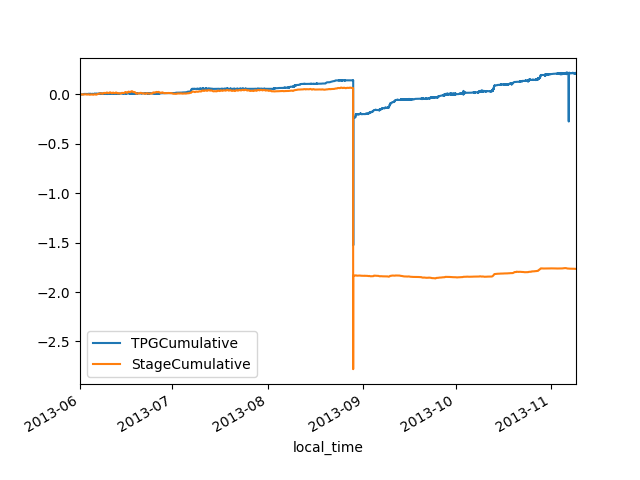

In [29]:
#Precip
precip_columns=['TPGCumulative', 'StageCumulative']
#precip_column_basenames=[precip_col.split("Cumulative")[0] for precip_col in precip_columns]

dat_original=dat.copy() #save unaltered data for later comparrison
dat_original=dat_original[precip_columns] #subset to only precip columns
#dat_original[precip_columns].columns=[x + " Original" for x in precip_column_basenames]
dat_original.plot()

In [30]:
#Set gages to NAN, when not installed (single gauge style does not cover period of record)
for precip_col in precip_columns:
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan

** Remove Gauge Drain and Fill Maintenance **

In [31]:
#Remove unrealistically large instantaneous jumps; create continuous timreseries
for precip_col in precip_columns:
    dat.loc[:,precip_col]=LVL1.precip_remove_obvious_sensor_malfunctions(dat_original[precip_col], obvious_error_precip_cutoff)

dat_step0=dat[precip_columns].copy() #save for plotting

<IPython.core.display.Javascript object>


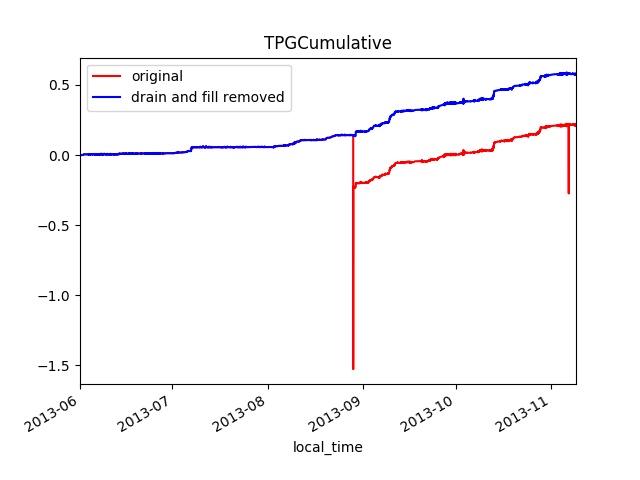

In [36]:
#Plot
%matplotlib notebook
LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[0], label_old="original", label_new="drain and fill removed")

<IPython.core.display.Javascript object>


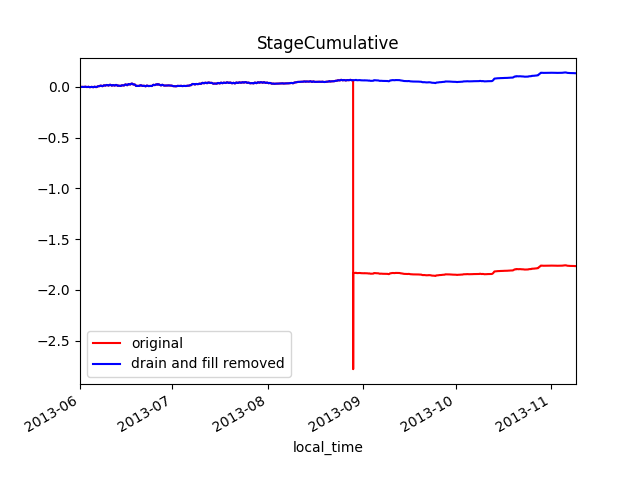

In [35]:
#Plot other precip gage
%matplotlib notebook
LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[1], label_old="original", label_new="drain and fill removed")

#### Remove high-amplitude noise related to wind

In [37]:
#Remove high-amplitude noise, related to wind, etc.
for precip_col in precip_columns:
    dat.loc[:, precip_col]=LVL1.precip_remove_high_frequency_noiseNayak2010(dat_step0[precip_col], noise=0.0025, bucket_fill_drain_cutoff=0.3, n_forward_noise_free=20)
dat_step1=dat[precip_columns].copy() #save for plotting

<IPython.core.display.Javascript object>


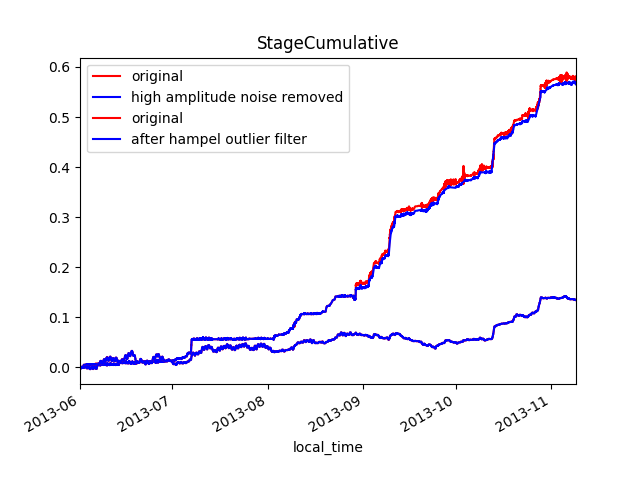

In [39]:
#Plot results
%matplotlib notebook
LVL1.plot_comparrison(df_old=dat_step0, df_new=dat_step1, data_col_name=precip_columns[0], label_old="original", label_new="high amplitude noise removed")

In [40]:
#Strip Remaining Outlier Values with Hampel Filter
for precip_col in precip_columns:
    dat.loc[:,precip_col]=LVL1.hampel(dat_step1[precip_col])
dat_step2=dat[precip_columns].copy() #save for plotting

<IPython.core.display.Javascript object>


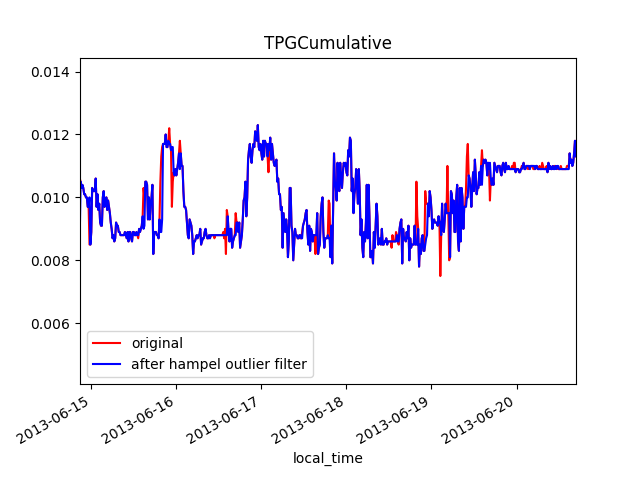

In [52]:
#Plot results
%matplotlib notebook
LVL1.plot_comparrison(df_old=dat_step1, df_new=dat_step2, data_col_name=precip_columns[0], label_old="original", label_new="after hampel outlier filter")

**Smooth Data with method from Nayak (2010): **

In [57]:
imp.reload(LVL1)

<module 'LVL1' from 'C:\\Users\\ehbaker\\Documents\\Python\\WXmunge\\LVL1.py'>

In [58]:
#Smooth Incremental Precip Data
for precip_col in precip_columns:
    #Smooth this data with method from Nayak 2010
    print ("smoothing "+ precip_col)
    dat[precip_col]=LVL1.smooth_precip_Nayak2010(dat[precip_col])
dat_step3=dat[precip_columns].copy() #save for plotting

smoothing TPGCumulative
  smoothing data in forward direction; may take a minute
  smoothing data in reverse direction; may take a minute
smoothing StageCumulative
  smoothing data in forward direction; may take a minute
  smoothing data in reverse direction; may take a minute


<IPython.core.display.Javascript object>


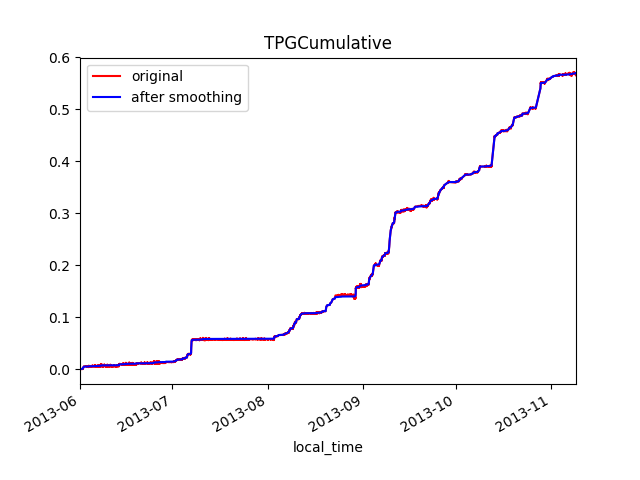

In [60]:
#Plot
%matplotlib notebook
LVL1.plot_comparrison(df_old=dat_step2, df_new=dat_step3, data_col_name=precip_columns[0], label_old="original", label_new="after smoothing")

Final Steps

In [71]:
#Convert units from meters to mm
for precip_col in precip_columns:
    dat.loc[:,precip_col]=dat[precip_col]*1000

#Set no-data values before TPG installed, and after rocket removed to NAN (not 0)
for precip_col in precip_columns:
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan

## Save Edited Data

In [72]:
#Create time as text column
dat['Local_time']=dat.index.tz_convert(local_timezone).strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)
#Column Names
out_columns=['Local_time']+temp_columns+precip_columns+['RelHum', 'WindSpeed', 'WindGustSpeed', 'WindDir', 'LoggerTemp','LoggerBattery']
#Subset
save_dat=dat[out_columns] #removes unwanted columns

#Save
save_dat.to_csv(save_pth, index=False, float_format='%g')